*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [1]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

     |████████████████████████████████| 399.9MB 35kB/s 
     |████████████████████████████████| 471kB 48.3MB/s 
     |████████████████████████████████| 12.2MB 201kB/s 
     |████████████████████████████████| 4.0MB 48.3MB/s 
     |████████████████████████████████| 4.0MB 51.6MB/s 
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
2.5.0-dev20210109


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2021-01-09 17:39:00--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv          [ <=>                ] 349.84K  --.-KB/s    in 0.03s   

2021-01-09 17:39:00 (10.8 MB/s) - ‘train-data.tsv’ saved [358233]

--2021-01-09 17:39:00--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv          [ <=>                ] 115

In [3]:
# load data from files into dataframes
train_dataset = pd.read_csv(
    filepath_or_buffer=train_file_path,
    sep='\t',
    names=["isSpam", "message"],
    dtype={"isSpam": "str", "message": "str"}
)

test_dataset = pd.read_csv(
    filepath_or_buffer=test_file_path,
    sep='\t',
    names=["isSpam", "message"],
    dtype={"isSpam": "str", "message": "str"}
)

print(train_dataset)
print(train_dataset.describe())
print(test_dataset.describe())

     isSpam                                            message
0       ham  ahhhh...just woken up!had a bad dream about u ...
1       ham                           you can never do nothing
2       ham  now u sound like manky scouse boy steve,like! ...
3       ham  mum say we wan to go then go... then she can s...
4       ham  never y lei... i v lazy... got wat? dat day ü ...
...     ...                                                ...
4174    ham  just woke up. yeesh its late. but i didn't fal...
4175    ham  what do u reckon as need 2 arrange transport i...
4176   spam  free entry into our £250 weekly competition ju...
4177   spam  -pls stop bootydelious (32/f) is inviting you ...
4178    ham  tell my  bad character which u dnt lik in me. ...

[4179 rows x 2 columns]
       isSpam                 message
count    4179                    4179
unique      2                    3935
top       ham  sorry, i'll call later
freq     3619                      22
       isSpam                

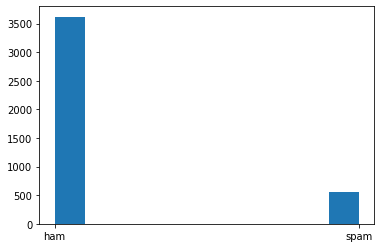

count     4179
unique       2
top        ham
freq      3619
Name: isSpam, dtype: object

In [4]:
plt.hist(train_dataset["isSpam"])
plt.show()

train_dataset["isSpam"].describe()

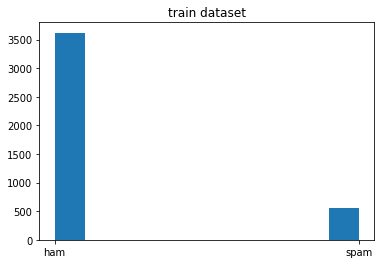

count     4179
unique       2
top        ham
freq      3619
Name: isSpam, dtype: object


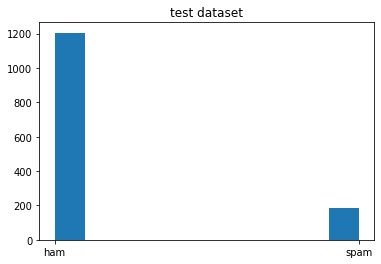

count     1392
unique       2
top        ham
freq      1205
Name: isSpam, dtype: object


In [5]:
# plot distributions of ham and spam messages
plt.hist(train_dataset["isSpam"])
plt.title("train dataset")
plt.show()

print(train_dataset["isSpam"].describe())

plt.hist(test_dataset["isSpam"])
plt.title("test dataset")
plt.show()

print(test_dataset["isSpam"].describe())

In [6]:
# split in ham and spam dataset...
train_ham_dataset = train_dataset[train_dataset.isSpam == "ham"]
train_spam_dataset = train_dataset[train_dataset.isSpam == "spam"]

print(len(train_spam_dataset))
print(len(train_ham_dataset))

# ...to downsample the ham messages - get same number of ham and spam messages
train_ham_dataset_short = train_ham_dataset.sample(n=len(train_spam_dataset), random_state=10)
train_dataset_short = train_ham_dataset_short.append(train_spam_dataset).reset_index(drop=True)

print(train_dataset_short)
print(train_dataset_short.describe())


# and do the same for the test data
test_ham_dataset = test_dataset[test_dataset.isSpam == "ham"]
test_spam_dataset = test_dataset[test_dataset.isSpam == "spam"]

test_ham_dataset_short = test_ham_dataset.sample(n=len(test_spam_dataset), random_state=10)
test_dataset_short = test_ham_dataset_short.append(test_spam_dataset).reset_index(drop=True)

560
3619
     isSpam                                            message
0       ham  he says hi and to get your ass back to south t...
1       ham  i know you are thinkin malaria. but relax, chi...
2       ham                                                 ok
3       ham                       were gonna go get some tacos
4       ham                                er yep sure. props?
...     ...                                                ...
1115   spam  free msg: single? find a partner in your area!...
1116   spam  free2day sexy st george's day pic of jordan!tx...
1117   spam  you are a winner you have been specially selec...
1118   spam  free entry into our £250 weekly competition ju...
1119   spam  -pls stop bootydelious (32/f) is inviting you ...

[1120 rows x 2 columns]
       isSpam                 message
count    1120                    1120
unique      2                    1056
top      spam  sorry, i'll call later
freq      560                       5


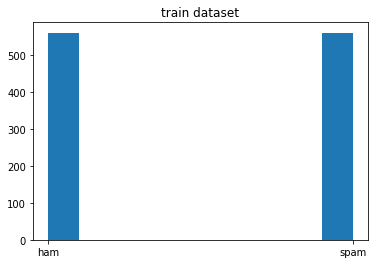

count     1120
unique       2
top       spam
freq       560
Name: isSpam, dtype: object


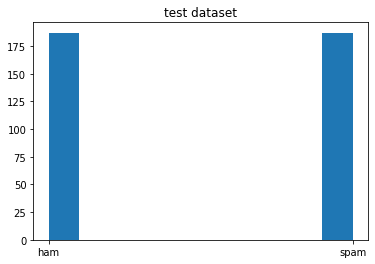

count     374
unique      2
top       ham
freq      187
Name: isSpam, dtype: object


In [7]:
# plot distribution of ham and spam messages in downsampled datasets
plt.hist(train_dataset_short["isSpam"])
plt.title("train dataset")
plt.show()

print(train_dataset_short["isSpam"].describe())

plt.hist(test_dataset_short["isSpam"])
plt.title("test dataset")
plt.show()

print(test_dataset_short["isSpam"].describe())

In [8]:
# numerize classes 'ham' and 'spam' to 0 and 1
train_dataset_short["isSpam"] = train_dataset_short["isSpam"].map({"ham": 0, "spam": 1})
test_dataset_short["isSpam"] = test_dataset_short["isSpam"].map({"ham": 0, "spam": 1})

# split datasets into data and labels
train_labels = train_dataset_short["isSpam"]
train_data = train_dataset_short["message"]

test_labels = test_dataset_short["isSpam"]
test_data = test_dataset_short["message"]

print(train_labels.describe())
print(train_data.describe())
print(train_data)

count    1120.000000
mean        0.500000
std         0.500223
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: isSpam, dtype: float64
count                       1120
unique                      1056
top       sorry, i'll call later
freq                           5
Name: message, dtype: object
0       he says hi and to get your ass back to south t...
1       i know you are thinkin malaria. but relax, chi...
2                                                      ok
3                            were gonna go get some tacos
4                                     er yep sure. props?
                              ...                        
1115    free msg: single? find a partner in your area!...
1116    free2day sexy st george's day pic of jordan!tx...
1117    you are a winner you have been specially selec...
1118    free entry into our £250 weekly competition ju...
1119    -pls stop bootydelious (32/f) is inviting you ...
Name

In [9]:
# define tokenization - give each word a unique integer id
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=10000,
    char_level=False,
    oov_token="<OOV>" # "...replacement for out-of-vocabulary words during text_to_sequence calls"
)
tokenizer.fit_on_texts(train_data)

In [10]:
word_index = tokenizer.word_index
print(word_index)

num_words = len(word_index)
print("len(word_index) = ", num_words)

print(tokenizer.texts_to_sequences(["you and i and something else and whatever"]))

{'<OOV>': 1, 'to': 2, 'you': 3, 'a': 4, 'i': 5, 'the': 6, 'call': 7, 'your': 8, 'for': 9, 'u': 10, 'now': 11, 'free': 12, 'is': 13, 'and': 14, '2': 15, 'or': 16, 'in': 17, 'on': 18, 'of': 19, 'ur': 20, 'have': 21, 'txt': 22, '4': 23, 'are': 24, 'with': 25, 'from': 26, 'me': 27, 'get': 28, 'mobile': 29, 'stop': 30, 'text': 31, 'this': 32, 'no': 33, 'just': 34, 'my': 35, 'reply': 36, 'it': 37, 'www': 38, 'be': 39, 'will': 40, 'can': 41, 'so': 42, 'only': 43, 'out': 44, 'claim': 45, 'send': 46, 'our': 47, 'we': 48, 'at': 49, 'but': 50, 'not': 51, 'that': 52, 'do': 53, 'new': 54, 'prize': 55, 'go': 56, 'if': 57, "i'm": 58, 'week': 59, 't': 60, 'nokia': 61, 'how': 62, 'cash': 63, 'uk': 64, '150p': 65, 'what': 66, 'up': 67, 'com': 68, 'know': 69, 'please': 70, 'who': 71, 'win': 72, 'as': 73, '1': 74, 'been': 75, 'won': 76, 'tone': 77, 'co': 78, 'urgent': 79, '50': 80, 'msg': 81, 'service': 82, 'by': 83, 'like': 84, 'all': 85, 'phone': 86, 'got': 87, 'has': 88, 'day': 89, 'time': 90, 'contact

In [11]:
# tokenize messages
train_data_tokenized = tokenizer.texts_to_sequences(train_data)
test_data_tokenized = tokenizer.texts_to_sequences(test_data)

print(train_data_tokenized)
print(len(train_data_tokenized[0]))

max_len = 75

# pad tokenized sequences - give all sequences the same length
train_data_tokenized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences=train_data_tokenized,
    maxlen=max_len,
    padding='post',
    truncating='post'
)
test_data_tokenized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences=test_data_tokenized,
    maxlen=max_len,
    padding='post',
    truncating='post'
)

print(train_data_tokenized_padded)
print(len(train_data_tokenized_padded[0]))
print(train_data_tokenized_padded.shape)
print(test_data_tokenized_padded.shape)

[[169, 759, 104, 14, 2, 28, 8, 1204, 108, 2, 1829, 1830, 1831, 49, 4, 1832], [5, 69, 3, 24, 1833, 941, 50, 1834, 760, 276, 1835, 941, 111, 357, 21, 75, 1836, 14, 114, 1837, 57, 111, 557, 437, 2, 1838, 157, 1839, 157, 1840, 40, 1841, 14, 57, 3, 252, 157, 941, 1842, 11, 111, 40, 34, 1205, 114, 4, 1206, 1843, 1844, 111, 88, 438, 1207, 17, 4, 942, 277, 37, 40, 943, 30], [105], [328, 394, 56, 28, 174, 1845], [1846, 1208, 558, 1847], [1848, 43, 1209, 49, 115, 116, 2, 15, 1210], [93, 439, 761, 62, 24, 3], [105, 358, 230, 10, 231, 130, 1849, 19, 231, 1211], [66, 232, 5, 559, 1850, 560, 1851], [66, 494, 1212, 1852, 495, 650], [1213, 394, 1214, 83, 17, 4, 1853, 440], [233, 395, 131, 10, 51, 561, 651, 562, 194], [30, 6, 762, 358, 278, 221, 358, 1854, 37, 14, 652, 1855, 5, 232, 51, 329, 279, 37], [944, 10, 441, 53, 131, 1856], [945, 276, 98, 2, 1857, 50, 46, 496, 73, 763, 1858, 276, 98, 2, 1859, 50, 46, 496, 73, 1215, 5, 276, 98, 2, 304, 10, 50, 41, 46, 35, 396, 73, 81, 2, 10, 280, 1860], [253, 14

In [12]:
# define model
model = keras.Sequential()

model.add(keras.layers.Embedding(input_dim=num_words+1, output_dim=16, input_length=max_len))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(24, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 75, 16)            63584     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


In [13]:
# fit model to train data
history = model.fit(
    x=train_data_tokenized_padded,
    y=train_labels,
    epochs=40,
    validation_data=(test_data_tokenized_padded, test_labels),
    verbose=2
)

Epoch 1/40
35/35 - 1s - loss: 0.6909 - accuracy: 0.5107 - val_loss: 0.6863 - val_accuracy: 0.5000
Epoch 2/40
35/35 - 0s - loss: 0.6799 - accuracy: 0.5321 - val_loss: 0.6718 - val_accuracy: 0.5802
Epoch 3/40
35/35 - 0s - loss: 0.6559 - accuracy: 0.6920 - val_loss: 0.6391 - val_accuracy: 0.8075
Epoch 4/40
35/35 - 0s - loss: 0.6083 - accuracy: 0.8339 - val_loss: 0.5789 - val_accuracy: 0.8850
Epoch 5/40
35/35 - 0s - loss: 0.5315 - accuracy: 0.8955 - val_loss: 0.4939 - val_accuracy: 0.9091
Epoch 6/40
35/35 - 0s - loss: 0.4326 - accuracy: 0.9250 - val_loss: 0.3998 - val_accuracy: 0.9251
Epoch 7/40
35/35 - 0s - loss: 0.3321 - accuracy: 0.9393 - val_loss: 0.3123 - val_accuracy: 0.9278
Epoch 8/40
35/35 - 0s - loss: 0.2515 - accuracy: 0.9527 - val_loss: 0.2486 - val_accuracy: 0.9358
Epoch 9/40
35/35 - 0s - loss: 0.1934 - accuracy: 0.9607 - val_loss: 0.2141 - val_accuracy: 0.9278
Epoch 10/40
35/35 - 0s - loss: 0.1540 - accuracy: 0.9696 - val_loss: 0.1758 - val_accuracy: 0.9519
Epoch 11/40
35/35 -

In [14]:
model.evaluate(test_data_tokenized_padded, test_labels)

12/12 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9679


[0.09411496669054031, 0.9679144620895386]

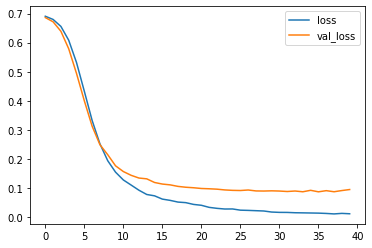

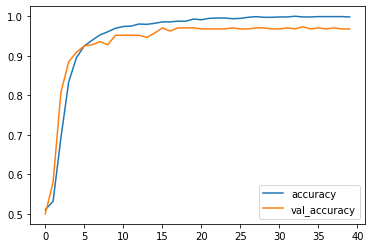

In [15]:
# plot some info about the fit
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [16]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  prediction_sequence = tf.keras.preprocessing.sequence.pad_sequences(
      sequences=tokenizer.texts_to_sequences([pred_text]),
      maxlen=max_len,
      padding='post',
      truncating='post'
  )
  
  prediction = model.predict(prediction_sequence)[0][0]

  if prediction <= 0.5:
    prediction=[prediction, "ham"]
  else:
    prediction=[prediction, "spam"]

  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.0035904348, 'ham']


In [17]:
# see predictions for test_messages - see if test would pass
test_messages = ["how are you doing today",
                 "sale today! to stop texts call 98912460324",
                 "i dont want to go. can we try it a different day? available sat",
                 "our new mobile video service is live. just install on your phone to start watching.",
                 "you have won £1000 cash! call to claim your prize.",
                 "i'll bring it tomorrow. don't forget the milk.",
                 "wow, is your arm alright. that happened to me one time too"
                ]

for msg in test_messages:
  print(predict_message(msg))

[0.0035904348, 'ham']
[0.5175616, 'spam']
[0.001832366, 'ham']
[0.9948077, 'spam']
[0.99747056, 'spam']
[0.0022736788, 'ham']
[0.014011353, 'ham']


In [18]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
